In [1]:
from gymnasium import Env
from gymnasium.spaces.box import Box
import numpy as np
import random
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.noise import NormalActionNoise
import wandb
from wandb.integration.sb3 import WandbCallback
import os
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pickle
import warnings
import math
warnings.filterwarnings("ignore")

In [10]:
class BobinaEnvTest(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just two degrees of freedom.
  """
  def __init__(self, alive = 20, masa_pod = 250, airgap = 16.3, duration = 10, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100, -100]), high = np.array([100, 100]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([-10, -10, -10, -10, -45, -45]), high = np.array([10, 10, 10, 10, 45, 45]), dtype=np.float32)
    # Initial parameters
    airgap = random.uniform(15.3, 17.3)
    self.state = np.array([airgap - 16.3, airgap - 16.3, airgap - 16.3, airgap - 16.3, 0, 0])
    self.airgapinicial = airgap
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = self.airgapinicial, dist_cm = dist_cm, inercia= inercia, min_distance = min_distance, max_distance = max_distance)
    self.steps = []
    self.airgap1 = airgap
    self.airgap2 = airgap
    self.distancia1 = 0
    self.distancia2 = 0
    self.velocidad = 0
    self.current1 = 0
    self.current2 = 0
    self.alive = alive
    self.vel = 0
    self.velangular = 0


  def step(self, action):
    # Apply action
    
    self.state, self.crash = self.sistema.step(action[0],action[1])
    self.distancia11, self.distancia12, self.distancia21, self.distancia22, self.current1, self.current2 = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    reward = -abs(self.distancia12) -abs(self.distancia22) - 10000*self.crash

    """if self.airgap >= 23: reward = -500
    elif self.airgap <= 10: reward = -500
    else: reward = -abs(self.current)"""

    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    """if self.crash:
      reward = - 100000
      terminated = True
    else:
      terminated = False"""
    terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes", normalize = True, seed = 0):
    # create data
    x = list(range(0,len(self.steps)))
    y1 = [16.3+step[0] for step in self.steps]
    y2 = [16.3+step[1] for step in self.steps]
    objective = [16.3]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    #ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    #ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black
    if normalize: ax.set_ylim(bottom=8, top=23)
    plt.xlabel("Time (s)") #, color='white')
    plt.ylabel("Airgap (mm)") #, color='white')
    plt.title("Airgap evolution") #, color='white')

    plt.plot(x, y1, label = "Airgap 1")
    plt.plot(x, y2, label = "Airgap 2")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    #if self.steps[0][0] < 0: plt.savefig("images/top-2gdl8x8nocrash.png")
    #else: plt.savefig("images/bottom-2gdl8x8nocrash.png")
    plt.savefig(f"images/2gdl8x8nocrashsituation{seed}.png")
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.uniform(9.5, 22)
    #self.state = np.array([airgap - 16.3, airgap - 16.3, 0, 0, 0, 0])
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = airgap, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5)
    angulo = random.uniform(-0.008, 0.008)
    self.vel1 = random.uniform(-0.2, 0.2)
    self.velangular = random.uniform(-0.3, 0.3)
    self.current1 = 0
    self.current2 = 0
    airgap1, airgap2 = self.sistema.pos2airgap(pos = airgap, theta = angulo)
    self.distancia1, self.distancia2 = airgap1-16.3, airgap2-16.3
    self.state= self.distancia1, self.distancia2, self.vel, self.velangular, self.current1, self.current2
    self.sistema.integral_aceleracion = self.vel
    self.sistema.integral_alpha = self.velangular
    self.sistema.integral_omega = angulo
    self.state, self.crash = self.sistema.step(0,0)
    self.distancia11, self.distancia12, self.distancia21, self.distancia22, self.current1, self.current2 = self.state
    
    
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [14]:
class BobinaEnv(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just two degrees of freedom.
  """
  def __init__(self, alive = 20, masa_pod = 250, airgap = 16.3, duration = 10, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100, -100]), high = np.array([100, 100]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([-10, -10, -np.inf, -np.inf, -45, -45]), high = np.array([10, 10, np.inf, np.inf, 45, 45]), dtype=np.float32)
    # Initial parameters
    airgap = 16.3
    angulo = random.uniform(-0.008, 0.008)
    self.airgapinicial = airgap
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = self.airgapinicial, dist_cm = dist_cm, inercia= inercia, min_distance = min_distance, max_distance = max_distance)

    
    #airgap1, airgap2 = self.sistema.pos2airgap(pos = airgap, theta = angulo)
    
    self.state = np.array([airgap - 16.3, airgap - 16.3, 0, 0, 0, 0])
   # self.sistema.integral_omega = angulo

    self.steps = []
    self.airgap1 = airgap
    self.airgap2 = airgap
    """self.distancia1 = 0
    self.distancia2 = 0"""
    self.distancia1, self.distancia2 = airgap-16.3, airgap-16.3
    self.velocidad = 0
    self.current1 = 0
    self.current2 = 0
    self.alive = alive
    self.vel = 0
    self.velangular = 0


  def step(self, action):
    # Apply action
    self.state, self.crash, angulo, error = self.sistema.step(action[0],action[1])
    self.distancia1, self.distancia2, self.vel, self.velangular, self.current1, self.current2 = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    reward = -abs(self.distancia1) -abs(self.distancia2) - 10000*self.crash

    """if self.airgap >= 23: reward = -500
    elif self.airgap <= 10: reward = -500
    else: reward = -abs(self.current)"""

    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    """if self.crash:
      reward = - 100000
      terminated = True
    else:
      terminated = False"""
    terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes", normalize = True, seed = 0):
    # create data
    x = list(range(0,len(self.steps)))
    y1 = [16.3+step[0] for step in self.steps]
    y2 = [16.3+step[1] for step in self.steps]
    objective = [16.3]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    #ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    #ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black
    if normalize: ax.set_ylim(bottom=8, top=23)
    plt.xlabel("Time (s)") #, color='white')
    plt.ylabel("Airgap (mm)") #, color='white')
    plt.title("Airgap evolution") #, color='white')

    plt.plot(x, y1, label = "Airgap 1")
    plt.plot(x, y2, label = "Airgap 2")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    #if self.steps[0][0] < 0: plt.savefig("images/top-2gdl8x8nocrash.png")
    #else: plt.savefig("images/bottom-2gdl8x8nocrash.png")
    plt.savefig(f"images/2gdl8x8nocrashsituation{seed}.png")
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.choice([10, 22])
    #angulo = random.uniform(-0.005, 0.005)
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = airgap, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5)
    #airgap1, airgap2 = self.sistema.pos2airgap(pos = airgap, theta = angulo)
    #self.distancia1, self.distancia2 = airgap1-16.3, airgap2-16.3
    self.state = np.array([airgap - 16.3, airgap - 16.3, 0, 0, 0, 0])
    #self.sistema.integral_omega = angulo
    
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [3]:
class Bobina():
  """ 
  Coil model for the Hybrid Electromagnetic Suspension
  """
  def __init__(self, masa_pod = 250, airgap = 22.5, min_distance = 9, max_distance = 22.5):
    self.masa_pod = masa_pod
    self.airgap = airgap
    self.aceleracion = []
    self.velocidad = []
    mat = scipy.io.loadmat('./coil/hems.mat')
    self.hems = mat["hems"][0][0]
    self.airgaps = self.hems[0][0]
    self.currents = self.hems[1][0]
    self.force_vertical = pickle.load(open("./coil/mlp_vertical.pkl", 'rb'))
    self.flux = self.hems[3]
    self.force_horizontal = self.hems[4]
    self.inductance = pickle.load(open("./coil/rf_inductance.pkl", 'rb'))
    self.resistance = self.hems[6][0][0]
    self.min_distance = min_distance
    self.max_distance = max_distance
    self.airgapinicial = airgap
    self.crash = False
    self.current = 0
    self.steps_RL = []

  def integral(self, lista, h = 1):
    return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))

  def RL(self, airgap, target_voltage, temperature):
    # Resistance-Inductance circuit

    # Get resistance of the coil
    R = self.R(current = self.current, temperature = temperature)   
    V = target_voltage
    I = self.current
    L = self.L(airgap = airgap, current = self.current)
    dIdt = ((V/R) - I)/(L/R)                                      
    self.steps_RL.append(dIdt)                                   
    current = self.integral(self.steps_RL, h = 0.001)                          
    return current                                                  

  def R(self, current, temperature):
    return self.resistance                                         

  def L(self, airgap, current):
    # Return predicted inductance
    return float(self.inductance.predict(np.array([[airgap, current]]))[0])

  def vertical_force(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < -45:
      I = -45
    self.current = I
    # Get vertical force from 
    FI = self.FI_vertical(airgap = airgap, current = I)                    
    return FI, I


  def FI_vertical(self, airgap, current):
    # Return predicted vertical force
    return float(self.force_vertical.predict(np.array([[airgap, current]])))    


  def next_airgap(self, masa_pod, vertical_force, verbose = False):
    # Devide the mass of the pod by 4 coils
    masa = masa_pod/4  
    # Calculate weight
    peso = masa * 9.8    
    # Get total force                                                       
    fuerza = peso - vertical_force
    if verbose: print("Fuerza resultante: ", fuerza)   
    # Calculate acceleration                                     
    aceleracion = fuerza/masa
    if verbose: print("Aceleración: ", aceleracion)                                         
    self.aceleracion.append(aceleracion)       
    # Calculate velocity                                
    velocidad = self.integral(self.aceleracion, 0.001)
    if verbose: print("Integral primera (velocidad): ", velocidad)                          
    self.velocidad.append(velocidad)               
    # Calculate position (x1000 as to transform from m to mm)                            
    posicion = self.airgapinicial + self.integral(self.velocidad, 0.001)*1000 
    if verbose: print("Integral segunda (posición): ", posicion)

    # Clip position
    if posicion > self.max_distance:
      airgap = self.max_distance
      self.aceleracion = [0]
      self.velocidad = [0]  
      #self.crash = True     
      self.airgapinicial = self.max_distance                                               
    elif posicion < self.min_distance:
      airgap = self.min_distance
      self.aceleracion = [0]
      self.velocidad = [0]
      #self.crash = True
      self.airgapinicial = self.min_distance
    else: airgap = posicion
    return airgap, velocidad

  def step(self, target_voltage, verbose = False):
    # Calculate vertical force and current
    vertical_force, self.current = self.vertical_force(airgap = self.airgap, target_voltage = target_voltage, temperature = 40)
    if verbose: print("Fuerza vertical: ", vertical_force)
    # Calculate next airgap and velocity
    self.airgap, velocidad = self.next_airgap(self.masa_pod, vertical_force, verbose = verbose)
    #noise = np.random.normal(0,0.5)
    #self.airgap = self.airgap + noise     
    return (np.float32(self.airgap), np.float32(velocidad), np.float32(self.airgap - 16.3), np.float32(self.current)), self.crash

In [4]:
class TwoGDL():
    def __init__(self, masa_pod = 250, airgap = 22.5, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
        self.masa_pod = masa_pod
        self.airgap1 = airgap
        self.airgap1_list = [airgap]
        self.airgap2 = airgap
        self.airgap2_list = [airgap]
        self.dist_cm = dist_cm
        self.inercia = inercia
        self.airgapinicial = airgap
        self.min_distance = min_distance
        self.max_distance = max_distance
        self.b1 = Bobina(masa_pod = self.masa_pod, airgap = self.airgap1, min_distance = self.min_distance, max_distance = self.max_distance)
        self.b2 = Bobina(masa_pod = self.masa_pod, airgap = self.airgap2, min_distance = self.min_distance, max_distance = self.max_distance)
        self.crash = False
        self.angulo = [0]
        self.alpha = [0]
        self.integral_alpha = 0
        self.omega = [0]
        self.integral_omega = 0
        self.altura = [0]
        self.aceleracion = [0]
        self.integral_aceleracion = 0
        self.velocidad = [0]
        self.integral_velocidad = 0
    
    def integral(self, lista, h = 1):
        return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))
    
    def fast_integral(self, last, lista, h = 0.001):
        return last + h*(lista[-1]+lista[-2])/2
    
    def get_angulo(self, f1, f2):
        F1 = f1*self.dist_cm
        F2 = -f2*self.dist_cm
        M = F1+F2
        alpha = M/self.inercia
        self.alpha.append(alpha)
        omega = self.fast_integral(self.integral_alpha, self.alpha, 0.001)
        self.integral_alpha = omega
        self.omega.append(omega)
        angulo = self.fast_integral(self.integral_omega, self.omega, 0.001)
        self.integral_omega = angulo
        self.angulo.append(angulo)
        return angulo
    
    def get_altura(self, f1, f2):
        F = (self.masa_pod/2)*9.8 - f1 - f2
        a = F/(self.masa_pod/2)
        self.aceleracion.append(a)
        v = self.fast_integral(self.integral_aceleracion, self.aceleracion, 0.001)
        self.integral_aceleracion = v
        self.velocidad.append(v)
        zpos = self.fast_integral(self.integral_velocidad,self.velocidad, 0.001)
        self.integral_velocidad = zpos
        zpos = self.airgapinicial + zpos*1000
        self.altura.append(zpos)
        return zpos
    
    def pos2airgap(self, pos, theta):
        airgap1 = pos + self.dist_cm*math.sin(theta)*1000
        airgap2 = pos - self.dist_cm*math.sin(theta)*1000
        return airgap1, airgap2
    
    def step(self, target_voltage1, target_voltage2, verbose = False):
        # Calculate vertical force and current
        self.crash = False
        vertical_force1, current1 = self.b1.vertical_force(airgap = self.airgap1, target_voltage = target_voltage1, temperature = 40)
        vertical_force2, current2 = self.b2.vertical_force(airgap = self.airgap2, target_voltage = target_voltage2, temperature = 40)
        if verbose: print("Fuerza vertical 1: ", vertical_force1)
        if verbose: print("Fuerza vertical 2: ", vertical_force2)
        angulo = self.get_angulo(f1 = vertical_force1, f2 = vertical_force2)
        zpos = self.get_altura(f1 = vertical_force1, f2 = vertical_force2)
        self.airgap1, self.airgap2 = self.pos2airgap(pos = zpos, theta = angulo)
        self.airgap1_list.append(self.airgap1)
        self.airgap2_list.append(self.airgap2)
        if verbose: print("Airgap 1: ", self.airgap1)
        if verbose: print("Airgap 2: ", self.airgap2)
        if self.airgap1 > self.max_distance or self.airgap2 > self.max_distance:
            self.airgap1 = self.max_distance
            self.airgap2 = self.max_distance
            self.crash = True
            self.angulo = [0]
            self.alpha = [0]
            self.integral_alpha = 0
            self.omega = [0]
            self.integral_omega = 0
            self.altura = [0]
            self.aceleracion = [0]
            self.integral_aceleracion = 0
            self.velocidad = [0]
            self.integral_velocidad = 0
            self.airgapinicial = self.max_distance
        elif self.airgap1 < self.min_distance or self.airgap2 < self.min_distance:
            self.airgap1 = self.min_distance
            self.airgap2 = self.min_distance
            self.crash = True
            self.angulo = [0]
            self.alpha = [0]
            self.integral_alpha = 0
            self.omega = [0]
            self.integral_omega = 0
            self.altura = [0]
            self.aceleracion = [0]
            self.integral_aceleracion = 0
            self.velocidad = [0]
            self.integral_velocidad = 0
            self.airgapinicial = self.min_distance
        #return (np.float32(self.airgap1 -16.3), np.float32(self.airgap2-16.3), np.float32(current1), np.float32(current2)), self.crash
        return (np.float32(self.airgap1 -16.3), np.float32(self.airgap2-16.3), np.float32(self.integral_aceleracion), np.float32(self.integral_alpha), np.float32(current1), np.float32(current2)), self.crash, angulo, zpos - 16.3
        #return (np.float32(self.airgap1_list[-2] -16.3), np.float32(self.airgap1_list[-1] -16.3), np.float32(self.airgap2_list[-2] -16.3), np.float32(self.airgap2_list[-1] -16.3), np.float32(current1), np.float32(current2)), self.crash
        #añadir una que returnee los 2 errores y las 2 velocidades


In [26]:
run = wandb.init(
    project="2gdl",
    sync_tensorboard=True,
    monitor_gym=True,
)

In [22]:
# Create log dir
log_dir = "2gdl/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = BobinaEnv( duration = 5 )
env = Monitor(env, log_dir)

In [23]:
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

# para el critic , qf=[400, 300], para el actor pi=[300, 200]
policy_kwargs = dict(net_arch=dict(pi=[8, 8], qf=[256, 256]))
model = SAC("MlpPolicy", env,learning_rate = linear_schedule(0.001), policy_kwargs=policy_kwargs, verbose=1, tensorboard_log=log_dir)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [68]:
MODEL_PATH = f"models/2gdl8x8nocrash.2 copy/model.zip"

# Create and wrap the environment
env = BobinaEnv(duration = 5)

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = linear_schedule(0.0001))

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [30]:
# Create checkpoint callback
checkpoint_callback = CheckpointCallback(
    save_freq=10000, save_path=log_dir, name_prefix="2gdl"
)

callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=-350, verbose=1)
eval_callback = EvalCallback(env, callback_on_new_best=callback_on_best, verbose=1)

In [31]:
# Train the agent
model.learn(total_timesteps=10000000,
    callback=[
        checkpoint_callback,
        eval_callback,
        WandbCallback(
            gradient_save_freq=10000,
            model_save_path=f"models/2gdl8x8nocrash.2",
            model_save_freq=10000,
            verbose=2,
        ),
    ],
)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Logging to 2gdl/SAC_51
Eval num_timesteps=10000, episode_reward=-49521511.76 +/- 0.00
Episode length: 5000.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 5e+03     |
|    mean_reward     | -4.95e+07 |
| time/              |           |
|    total_timesteps | 10000     |
| train/             |           |
|    actor_loss      | 3.8e+05   |
|    critic_loss     | 3.91e+05  |
|    ent_coef        | 11.6      |
|    ent_coef_loss   | -0.177    |
|    learning_rate   | 0.000999  |
|    n_updates       | 11257     |
----------------------------------
New best mean reward!
Eval num_timesteps=20000, episode_reward=-934157.42 +/- 0.00
Episode length: 5000.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 5e+03     |
|    mean_reward     | -9.34e+05 |
| time/              |           |
|    total_timesteps | 20000     |
| train/             |           |
|    actor_loss      | 3.15e+0

KeyboardInterrupt: 

In [24]:
episodes = 3
state, seed = env.reset()
for episode in range(1, episodes+1):
    state, seed = env.reset()
    done = False
    score = 0
    while not done:
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-57087.66697450366
Episode:2 Score:-57169.60609087738
Episode:3 Score:-57424.86711319699


In [109]:
b = Bobina()
b.airgap = 9

In [108]:
b.step(100)

((20.00214, -0.10582279, 3.7021403, 45.0), False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[-6.3 -6.3  0.   0.   0.   0. ]
Time predict 10.924832820892334
Time model 67.07681846618652
Episode reward -21742.932198846713
[(0.0, 0.0), (-3.2980323, 3.2852898), (-6.4622445, 6.4871492), (-9.34559, 6.130542), (-11.946186, 2.1916382), (-14.27443, -1.5946237), (-16.39189, -4.9274845), (-18.371971, -7.931929), (-20.23514, -10.657313), (-21.990543, -13.097919), (-23.648859, -15.301554), (-25.22713, -17.3456), (-26.736614, -19.266346), (-28.184608, -21.073292), (-29.577755, -22.77825), (-30.921392, -24.400772), (-32.219673, -25.952799), (-33.47646, -27.434887), (-34.69315, -28.856543), (-35.870956, -30.226986), (-37.011204, -31.549433), (-38.1155, -32.827183), (-39.18497, -34.063858), (-40.220905, -35.261074), (-41.22466, -36.420116), (-42.197384, -37.542416), (-43.139988, -38.62894), (-44.053383, -39.680595), (-44.938683, -40.698597), (-45.0, -41.68392), (-45.0, -42.637135), (-45.0, -43.55853), (-45.0, -44.448

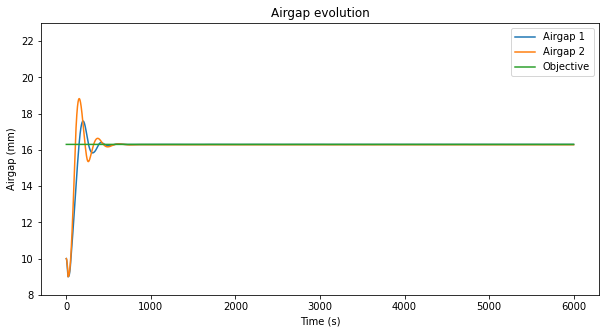

[5.7 5.7 0.  0.  0.  0. ]
Time predict 10.859762907028198
Time model 66.00779438018799
Episode reward -1158.638298745267
[(0.0, 0.0), (2.9835613, 2.9888337), (5.9398537, 5.951804), (8.847622, 8.868879), (11.754317, 11.786979), (14.67781, 14.72349), (17.57825, 17.638233), (20.448956, 20.527943), (23.29652, 23.431814), (26.143925, 26.345177), (28.942831, 29.192045), (31.593737, 31.905125), (34.069874, 34.456566), (36.390366, 36.850197), (38.580166, 39.103264), (40.648792, 41.224358), (42.60255, 43.21743), (44.441635, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (45.0, 45.0), (39.566925, 45.0), (36.635715, 45.0), (37.792313, 45.0), (39.37043, 45.0), (38.7

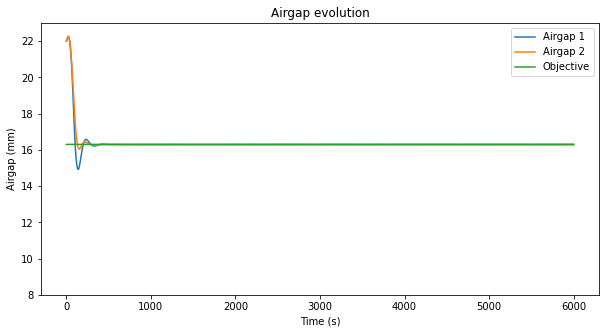

[-6.3 -6.3  0.   0.   0.   0. ]


KeyboardInterrupt: 

In [15]:
import numpy as np
import torch as th
import time

MODEL_PATH = f"models/2gdl8x8nocrash/model.zip"

# Create and wrap the environment
env = BobinaEnv(duration = 6)

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = 0.00001)

# Evaluate the agent
for i in range(5):
    obs, seed = env.reset()
    print(obs)
    done = False
    episode_reward = 0
    velocidad = 0
    current = 0
    observations = []
    noises = []
    timepredict = 0
    timemodel = 0
    distancia1, distancia2, vel, velangular, current1, current2 = obs
    while not done:
        #noise = random.uniform(-1, 1)
        #obs = obs + noise
        observations.append(obs)
        #noises.append(noise)
        t1 = time.time()
        action, _states = model.predict(np.array([distancia1, distancia2, vel, velangular, current1, current2]), deterministic=True)
        t2 = time.time()
        #print(action)
        #if env.airgap > 10.1: action = max(action, [-50])
        #print(action)
        t3 = time.time()
        state, reward, terminated, truncated, info = env.step(np.array(action))
        t4 = time.time()
        distancia1, distancia2, vel, velangular, current1, current2 = state
        done = truncated or terminated
        episode_reward += reward
        timepredict += t2 - t1
        timemodel += t4 - t3
        noises.append((current1, current2))
    print("Time predict", timepredict)
    print("Time model", timemodel)
    print("Episode reward", episode_reward)
    print(noises)
    env.render("yes", normalize = True, seed = i+5)

In [452]:
plt.savefig("images/floor-2gdl8x8nocrash.png")

<Figure size 432x288 with 0 Axes>

In [167]:
import torch as th

from stable_baselines3 import SAC

#import onnx
import onnxruntime as ort
import numpy as np


class OnnxablePolicy(th.nn.Module):
    def __init__(self, actor: th.nn.Module):
        super().__init__()
        # Removing the flatten layer because it can't be onnxed
        self.actor = th.nn.Sequential(
            actor.latent_pi,
            actor.mu,
            # For gSDE
            # th.nn.Hardtanh(min_val=-actor.clip_mean, max_val=actor.clip_mean),
            # Squash the output
            th.nn.Tanh(),
        )

    def forward(self, observation: th.Tensor) -> th.Tensor:
        # NOTE: You may have to process (normalize) observation in the correct
        #       way before using this. See `common.preprocessing.preprocess_obs`
        return self.actor(observation)


# Example: model = SAC("MlpPolicy", "Pendulum-v1")
model = SAC.load(f"models/sac8x8h9.3/model.zip", device="cpu")
onnxable_model = OnnxablePolicy(model.policy.actor)

observation_size = model.observation_space.shape
dummy_input = th.randn(1, *observation_size)
th.onnx.export(
    onnxable_model,
    dummy_input,
    "./ONNX/1gdlComplexH98x8.onnx",
    opset_version=9,
    input_names=["input"],
)

##### Load and test with onnx

import onnxruntime as ort
import numpy as np

onnx_path = "./ONNX/1gdlComplexH98x8.onnx"

observation = np.zeros((1, *observation_size)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
action = ort_sess.run(None, {"input": observation})

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



: 

In [12]:
model.policy

SACPolicy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=8, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=8, out_features=1, bias=True)
    (log_std): Linear(in_features=8, out_features=1, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (qf0): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
    (qf1): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
   

In [ ]:
# See "ONNX export" for imports and OnnxablePolicy
jit_path = "1gdlComplex.pt"

# Trace and optimize the module
traced_module = th.jit.trace(onnxable_model.eval(), dummy_input)
frozen_module = th.jit.freeze(traced_module)
frozen_module = th.jit.optimize_for_inference(frozen_module)
th.jit.save(frozen_module, jit_path)

##### Load and test with torch

import torch as th

dummy_input = th.randn(1, *observation_size)
loaded_module = th.jit.load(jit_path)
action_jit = loaded_module(dummy_input)